# FS20C7 - Recommendations im Detailhandel
### Autoren: Eugen Cuic, Lukas Reber
### Datum, Ort: 05.06.2020, FHNW Brugg-Windisch
### Studiengang: BSc Data Science

Das vorliegende Python Notebook wurde im Rahmen der Challenge "Recommendations im Detailshandel" im Frühlingssemester 2020 erarbeitet. Das Notebook funktioniert als User Interface, womit der/die Anwender*in jede Zelle sequenziell ausführen kann und die entsprechende Resultate angezeigt bekommt. Die Funktionen wurden in die jeweiligen Python Module ausgelagert. Die Funktionen sind mittels DocString beschrieben und können mit dem Befehl help(Name_der_Funktion) aufgerufen werden. 

Weiterführende Informationen zur Thema "Recommender Systems" und zum Aufbau des Programmcodes, sowie die Resultate der Evaluierung sind dem Dokument "FS20C7_Bericht_Cuic_Reber" zu entnehmen.

***

### Inhaltsverzeichnis:
 - Explorative Datenanalyse
   - Laden der Daten
      - Regulär
      - Speicheroptimiert durch "chunksize"
   - Auf fehlende Werte überprüfen
   - Grafische Analyse - Meistgekaufte Produkte
   - Grafische Analyse - Anzahl gekaufter Produkte / Bestellung
   - Grafische Analyse - Verteilung der Käufe pro Abteilung
   - Grafische Analyse - Anzahl getätigte Käufe pro Kunde
   - Numerische Analyse - Grenzwert für Bestellungen pro Kunde
 - Datenaufbereitung
   - Reduktion anhand von nicht benötigten Spalten
   - Datenreduktion
      - Reduktion der Transaktionen auf Basis der Topprodukte
      - Reduktion der Transaktionen auf Basis der total verschieden gekauften Produkten von User
      - Reduktion der Transaktionen auf Basis der Bestellungen von User
   - Reduktion anhand von nicht benötigten Spalten
   - Matrixerstellung
   - Split Train / Test Set / Maskierungen
   - Resultat des bereinigten Datensatzes
- Recommender Building
   - Memory-Based Recommender
   - Model Based Recommender
      - Bestimmung von sigma (singulärwert)
      - Matrix dekomposieren basiered auf sigma
      - Rekonsturktion der Bewertungsmatrix
      - Umwandlung der benötigten Matrizen in ein Pandas Frame für die einfachere Handhabung
      - Testlauf um Recomendations für einen User zu erstellen
      - Erstelle Recommendations für einen User inkl. Name des Produkts
- Evaluation
   - Memory-Based Recommender
   - Model Based Recommender
 

In [1]:
# Import der Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import der selbst erstellten Pyhton Module
from explorative_analysis import *
from datenaufbereitung import *
from matrixerstellung import *
from evaluation import *
from recommender import *


Bad key "text.kerning_factor" on line 4 in
C:\Users\M0268176\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Explorative Datenanalyse

## Laden der Daten

Da sich im Datensatz viele Daten befinden die für die weitere Betrachtung nicht verwendet werden, soll im ersten Schritt überprüft werden welche Spalten überhaupt zur Verfügung stehen um diese gleich zu Beginn zu eliminieren und dadruch das Laden der Daten, die Handhabung der Daten und eine bessere Nutzun des Computerspeichers zu erreichen. Dafür wir einmal überprüft was die Spalten aussagen:

Beschreibung der Atribute (bezugnehmend zu https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

- order_id: order identifier
- user_id: user identifier
- eval_set: which evaluation set this order belongs in (we only have Prior and Train) - no test?
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior_order: days since the last order, capped at 30 (with NaNs for order_number = 1)
- product_id: product identifier
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
- product_name: name of the product
- aisle_id: aisle identifier
- department_id: department identifier
- department: the name of the department
- ailse: the name of the aisle

### Laden der Daten - regulär

In [2]:
%%time
# Wenn durch gewisse Untersuchungen schon klar ist, welche Spalten nicht verwendet werden, dann kann beim laden angegeben werden, welche Spalten geladen werden und welche ausgelassen werden sollen
columns=['order_id', 'user_id', 'product_id', 'product_name', 'department']

#nrows=1000000: kann für Testzwecke gesetzt werden, wenn nicht der gesamte Datensatz eingelesen werden soll
data = pd.read_csv ('Recommender4Retail.csv', usecols=columns)
del columns

Wall time: 28.5 s


In [3]:
data.head(5)

,order_id,user_id,product_id,product_name,department
0,2539329,1,196,Soda,beverages
1,2539329,1,14084,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,12427,Original Beef Jerky,snacks
3,2539329,1,26088,Aged White Cheddar Popcorn,snacks
4,2539329,1,26405,XL Pick-A-Size Paper Towel Rolls,household


### Laden der Daten - Speicheroptimiert durch "chunksize"

In [4]:
%%time
# Falls die Daten auf einem Rechner geladen werden mit wenig Arbeitsspeicher (<8 GB), ist zu empfehlen das grosse CSV File mittels Chunks einzulesen. Eine Zeitersparnis kann durch diese Methode nicht erwirkt werden, lediglich eine effizientere Nutzung des Speichers
'''
columns=['order_id', 'user_id', 'product_id', 'product_name', 'department']

tp = pd.read_csv('Recommender4Retail.csv', iterator=True, usecols=columns, chunksize=1000000)
data = pd.concat(tp, ignore_index=True)

del columns
data.head(5)
'''

Wall time: 0 ns


"\ncolumns=['order_id', 'user_id', 'product_id', 'product_name', 'department']\n\ntp = pd.read_csv('Recommender4Retail.csv', iterator=True, usecols=columns, chunksize=1000000)\ndata = pd.concat(tp, ignore_index=True)\n\ndel columns\ndata.head(5)\n"

## Auf fehlende Werte überprüfen
Beim Überprüfen des Datensatzes mithilfe der info() Funktion ist ersichtlich, dass es keine fehlenden Werte gibt, die zu entfernen wären. Dazu werden die Anzahl not null Werte mit den totalen Werten verglichen

In [5]:
data.info(verbose=True, null_counts=True)

data.memory_usage()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 5 columns):
 #   Column        Non-Null Count     Dtype 
---  ------        --------------     ----- 
 0   order_id      33819106 non-null  int64 
 1   user_id       33819106 non-null  int64 
 2   product_id    33819106 non-null  int64 
 3   product_name  33819106 non-null  object
 4   department    33819106 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.3+ GB


Index                 128
order_id        270552848
user_id         270552848
product_id      270552848
product_name    270552848
department      270552848
dtype: int64

## Grafische Analyse - Meistgekaufte Produkte
Die folgende Grafik zeigt die 20 am meisten gekauften Produkte und die Anzahl, wie oft diese verkauft wurden.

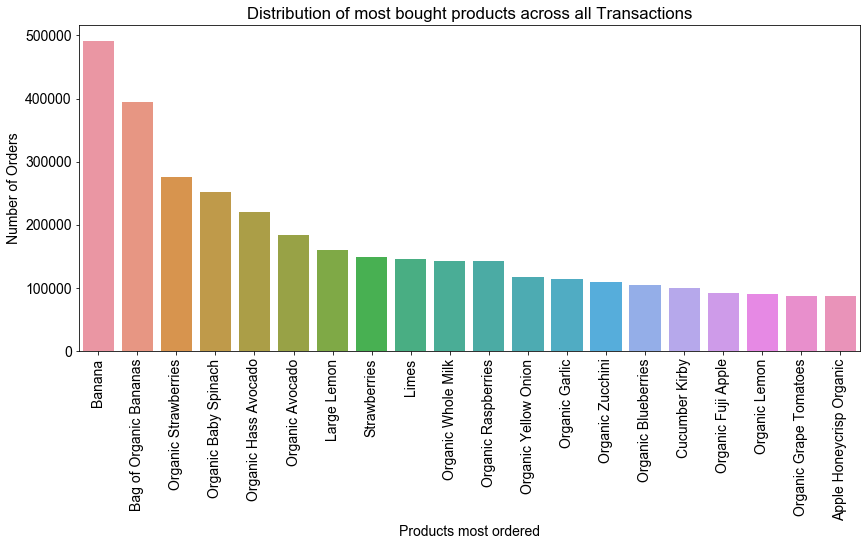

In [6]:
fig_prod_bought(data, 0)

## Grafische Analyse - Anzahl gekaufter Produkte / Bestellung

# @Lukas: besser so?

In diesem Output ist zu sehen wie sich die Verteilung der gekauften Produkte verhält. Es ist gut zu sehen dass die meisten Einkäufer 30 Produkte und weniger eingekauft haben pro Einkauf. Diesen Sachverhalt wird genutzt um in einem nächsten Schritt ein Rating abzuleiten, welches zwischen 0 und 1 normiert wird. Dabei wir angenommen, dass Produkte die öfters gekauft wurden auch wichtiger für einen Kunden sind. Um dies zu erreichen werden die Anzahl gekauften Produkte durch die maximale Anzahl eines Produktes dividiert

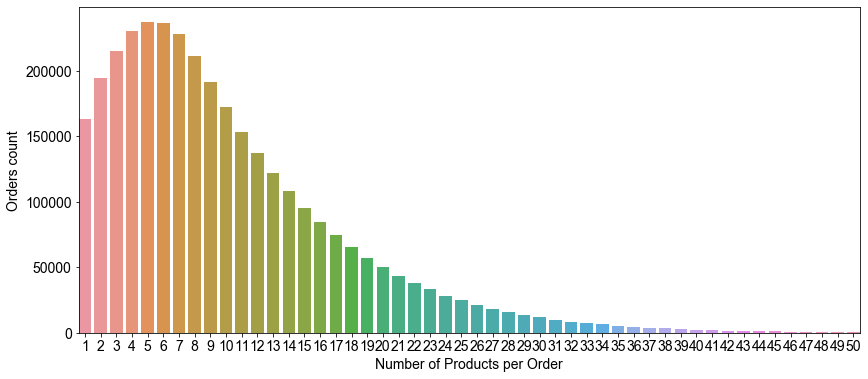

In [7]:
fig_prod_per_order(data, 0)

## Grafische Analyse - Verteilung der Käufe pro Abteilung
Der folgende Plot zeit visuell auf, Produkte welcher Produktkategorien am meisten gekauft werden. Diese Information kann verwendet werden, falls die Reduktion des Produktsortiments aufgrund von Produktekategorien gemacht werden soll. 

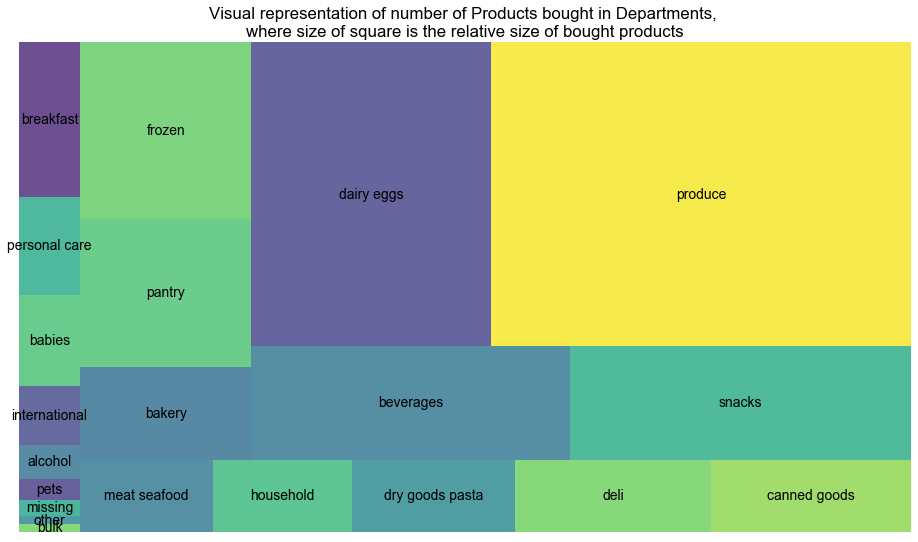

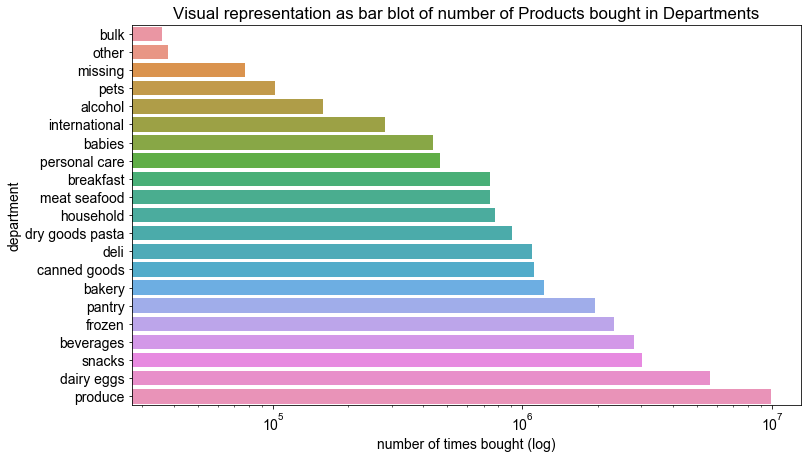

In [8]:
fig_ord_per_department(data, 0)

## Grafische Analyse - Anzahl getätigte Käufe pro Kunde

Die Bestellungen der Kunden mit wenig Bestellungen sind in der Regel durch wenig Aussagekraft gekennzeichnet. Aus diesem Grund sollen die Kunden, in späteren Schritten, entfernt werden die eine gewisse Anzahl Einkäufe nicht überschreiben. 

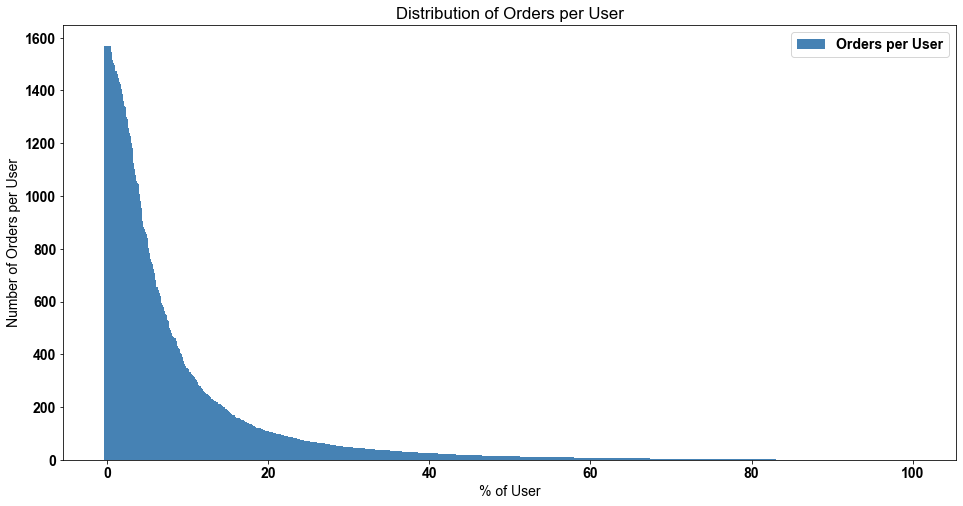

In [9]:
fig_n_of_ord_per_user(data)

## Numerische Analyse - Grenzwert für Bestellungen pro Kunde

Wie in der obigen Analse zu erkennen ist, ist die Abflachung der Bestellungen pro Kunde ziemlich steil. Um Kunden zu entfernen, die wenig Aussagekraft haben, werden solche mit einer geringen Anzahl an Bestellungen entfernt. Es soll in diesem Schritt mit 60% weniger User gearbeitet werden.

In [10]:
cal_limit_orders_per_user(data, 60)

Bei 25 Käufen pro Kunden können 60 Prozent der Kunden eliminiert werden


25

# Datenaufbereitung

Im folgenden Kapitel werden die Daten reduziert und in die korrekte Form gebracht.

## Reduktion anhand von benötigten Spalten

# Prüfen

In [11]:
#In diesem Schritt werden die Daten noch einmal gekürzt, da die Spalte "Department" und "Product_Name" nicht weiter verwendet werden. Laut memory_usage benötigt jede Spalte 270mb. Durch die Entferung von zwei Spalten kann der Memory Verbrauch um 2/5 gesenkt werden.
data.memory_usage()
del data['department']
del data['product_name']

## Datenreduktion
Im nächsten Abschnitt werden die Rohdaten vorbereitet bzw. gefiltert. Die Filterung der Daten kann direkten Einfluss auf die Qualität der berechneten Recommendations und besonders auch auf die Performance der Berechnungen haben. Beispielsweise ist es für User, welche eine geringe History haben, also nicht viele Produkte gekauft / bewertet haben, schwieriger passende Recommendations zu berechnen, da diese User nur ungenügend mit anderen Usern verglichen werden können. Des weiteren ist es sinnvoll, Produkte welche nur selten gekauft wurden, aus der Berechnung der Recommendations auszuschliessen, da diese vermutlich nie empfohlen werden. 

In diesem Modul wurden die folgenden Reduktionen des Datensatzen vorgenommen:

-	Produkte (Item), welchen nicht mindesten n mal gekauft wurden, werden entfernt
-	Kunden (User), welche nicht mindestens n Produkte gekauft haben, werden entfernt.
-	Kunden (User), welche nicht mindestens n Bestellungen gemacht haben, werden entfernt.

Als Resultat liegt ein reduzierter Datensatz vor, welcher Records enthält, welche für die Recommender Bildung die grösste Aussagekraft haben.

### Reduktion der Transaktionen auf Basis der Topprodukte

In der Aufgabenstellung der Challenge ist gefordert, dass der Produktekatalog um 80% redzuiert werden soll. In einem ersten Schritt, wird aufgelistet, welche Produkte wie oft gekauft wurden. Diese Liste wird sortiert nach der Häufigkeit der Verkaufszahlen. Anschliessend werden die Records gefiltert um nur noch Einträge zu berücksichtigen, welche den Top 20 Prozent der Produkte entsprechen.

Total sind im Datensatz 49685 Produkte vorhanden. Wird diese Anzahl auf 20% reduziert, bleiben noch 9937 Produkte. Gesamthaft befinden sich im Datensatz 33'819'106 Transaktionen; gefiltert auf die Top 20% der Produkte bleiben immer noch 30'749'657 Transaktionen vorhanden.

Dies führt weiter dazu, dass auch das Produkt, welches am wenigesten oft gekauft wurde, immer noch 393-mal verkauft wurde.


In [12]:
data = reduce_products(data, 0.2)

Total Number of Products: 49685
Number of Products after reduction: 9937


### Reduktion der Transaktionen auf Basis der total verschieden gekauften Produkten von User

Der Datensatz wird weiter reduziert, um nur User zu erhalten welche eine relevante Anzahl an Produkte gekauft haben. Im ersten Schritt wird aufgezeigt welche User wieviele Produkte gekauft haben. Anhand dieser Zahlen wird anschliessend eine Selektion der Top n User gemacht und die nicht benötigten aus den Transaktionen entfernt.

Hierbei ist bei der Evaluierung zu prüfen, welcher Wert die besten Resultate liefert.

In einer ersten Annahme wurden festgelegt, dass relevante User mindestens 30 verschiedene Produkte gekauft haben müssen. Die führt bei der Filterung der Records dazu, dass noch noch 28.5 Mio. Records vorhanden bleiben

In [13]:
data = reduce_users_prod(data, 30)

No. of Records in input dataset: 30749657
No. of Records after filtering: 28502393


### Reduktion der Transaktionen auf Basis der Bestellungen von User

In einem vorgängigen Schritt wurde berechnet, welche Menge an Einkäufen ein User mindestens haben muss, um berücksichtigt zu werden. Dabei wurden nicht relevante, respektive weniger aussagekräftige User entfent um die Grösse der Matrix so gering wie möglich zu halten.

# @Lukas: Können wir mit dieser Anzahl User leben?

In [14]:
# Entferne Users die den threshold der Einkäufe nicht erreichen
data = reduce_user_purch(data, 25)

print('Der Datensatz wird auf {0} User reduziert'.format(data['user_id'].nunique()))

Der Datensatz wird auf 34703 User reduziert


In [15]:
# Weitere Reduktion des Datensatzes für eine optimierte Handhabung. Entfernung der nicht benötigten Spalten
del data['order_id']

# Hinzufügen einer Spalte für das Zählen der Mengen
data['rating'] = 1

## Matrixerstellung

In diesem Modul wird aus dem reduzierten Datensatz eine User-Item Matrix generiert. Hierbei besteht die Möglichkeit die Ratings nach unterschiedlichen Berechnungsmethoden zu definieren. Die folgenden zwei Ansätze wurden implementiert: 
- Unary / Binary Rating: Das Rating sagt lediglich aus, ob ein User ein Item gekauft hat (1) oder nicht (0).
- Nominales Rating: Wert wie oft ein Produkt gekauft wurde. Das Rating wird auf einen Wert zwischen 0 und 1 normiert

HINWEIS:  Das nominale Rating ist jedoch nicht zwingend Aussagekräftig; Gewisse Items werden möglicherweise oft gekauft, aber nicht zwangsläufig vom User besser bewertet (z.B. WC-Papier, wird benötigt, muss aber nicht zwingend empfohlen werden)

In [16]:
%%time
# Erstelle Matrix mit unary Ratings 
matrix_unary = create_user_item_matrix(data,'unary')

Wall time: 2.62 s


In [17]:
%%time
# Erstelle Matrix mit count Ratings 
matrix_count, users, products = create_user_item_matrix(data,'count')

Wall time: 1.5 s


In [18]:
calc_sparsity(matrix_unary)
calc_sparsity(matrix_count)

98.74 % of the user interaction matrix is sparse
98.74 % of the user interaction matrix is sparse


In [19]:
matrix_unary

<34703x9937 sparse matrix of type '<class 'numpy.int64'>'
	with 4344038 stored elements in Compressed Sparse Row format>

@Eugen: Frage: wollen wir das hier tun oder im Bericht beschreiben?

@ Lukas: Machen wir es im Bericht, die Daten stehen in der Zwischenzeit schon unten und können abgeschrieben werden

## Resultat des bereinigten Datensatzes:
Nach der Reduktion der Daten und der Verkleinerung der Matrix, ist folgendes zu sehen:
- Die neue Matrix (Sparse) enthält (34703 Kunden, mit 9937 Produkten und insgesamt enthält die Matrix 4344038 Koombination von Käufer und Produkt 
- Die erste Erkentniss führt zur Aussage, dass 97.74 % der ursprünglichen Matrix leer ist

Wie nun gut zu sehen ist, sind 98.74% der Daten in der User-Item Matrix leer, bzw. mit Null befüllt. Eine Weiterführung mit einem solchen Datensatz wäre viel zu rechenintensiv und nicht performant. Die Verwendung einer Sparse Matrix erlaubt es in den fortführenden Schritten mehr Daten perfomanter zu benutzen.

In [20]:
# Löschen der ursprünglichen Datensätze, da diese nicht mehr gebraucht werden
del data

# @Lukas: kann der Text so verwendet werden? macht das sinn?

## Split Train / Test Set / Maskierungen

Aufteilung der Daten in Test- und Trainset respektive Maskierung von Werten. Es wurden zwei Ansätze implementiert

Ansatz:  N-Prozent der Ratings werden im Training Set maskiert. Das Testset enthält den vollständigen Datensatz
- --> (func: mask_test_train)

Ein weitere Ansatz der auch verwendet werden könnte, wäre zufällig User zu wählen anstatt die Ratings. Für die Art des Recommenders der hier verwendet wird, kann dieser aber nicht verwendet werden, weil somit nicht überprüft werden könnte ob die richtigen Produkte empfohlen worden sind. Die Funktion an sich ist im File "matrixerstellung.py" vermerkt

Ansatz: Zufällig N-Prozent aller User (**DEPRECIATED**):
- --> (func: split_test_train)

In [21]:
# Für ein UBCF müssen alle Kunden im Trainingset vorhanden sein, da auf Basis dieser Daten, Ähnlichkeiten von Benutzern berechnet werden. Fehlt ein User im Trainingsset, so ist keine Berechnung der Ähnlichkeit möglich.
'''
Output ist: 
- Ein Trainset, welches dem Daten maskiert (entfernt) hat
- Ein Testset, welches die kompletten Daten enthält
- Eine Liste der User bei welchen Daten maskiert wurden
- Eine Liste der Indexe der Ratings welche maskiert wurden
'''
# Testset entspricht der Input Matrix

# Train und Testset für unary Matrizen (->Maskierungen)
train_set_unary, users_masked_unary, index_masked_unary = mask_test_train(matrix_unary,0.1)
# Testset entspricht der Input Matrix

# Train und Testset für count Matrizen (->Maskierungen)
#train_set_count, users_masked_count, index_masked_count = mask_test_train(matrix_count, 0.1)


train_set_count, users_masked_count, index_masked_count = mask_test_train_count(matrix_count, 0.1, 0.2)

# Recommender Building

In diesem Modul werden die eigentlichen Recommendations berechnet. Es wurden zwei Modelle implementiert:
- Memory-Based: User-based collaborative filtering. Hierbei wird in der User-Item Matrix nach ähnlichen Usern gesucht und Items vorgeschlagen, welche bei diesen Usern am beliebtesten sind. Die ähnlichkeit von Users wird berechnet anhand der Items welche sie bisher gekauft haben.
- Modell-Based: Die User-Item Matrix wird mittels Matrix-Faktorisierung (Single Value Decomposition) in eine User-Factor und eine Factor-Item Matrix dekomposiert.

## Memory-Based Recommender

# @ Lukas:
## Wenn ich diese Funktion mit den 34k Usern laufen lasse, braucht mein Speicher an dieser Stelle 12GB. Sprich bei dir werden womöglich 4GB ausgelagert, was zu performance Schwierigkeiten führen könnte.

In [22]:
# User based Collaborative Filtering
# Es werden andere Kunden (Users) gesucht, welche in der Vergangenheit ein ähnliches Kaufverhalten aufweisen. Die Ratings dieser Kunden werden verwendet um vorherzusagen, wie gut ein Produkt (Item) dem Kunden gefallen könnte.

# Berechnung der Ähnlichkeit von Usern
sim = user_sim_v3(train_set_unary)

# Zusätzlich zu diesem Funktion befindet sich im Modul "matrixerstellung.py" auch eine user_sim, user_sim_v1 und user_sim_v2. Diese werden nicht benötigt, dienen lediglich Dokumentationszwecken.

# Hier braucht es 16GB Speicher, wobei 8GB schon voll sind durch die vorhergehenden Daten

In [23]:
# Berechnung der Nachbarschaft (Neighbourhood) auf Basis der Ähnlichkeit der User. Der Radius der Nachbarschaft kann definiert werden (zweiter Parameter der Funktion)
user_neighbours = user_hood(sim,5)

In [24]:
# Berechnung eines Ratings eines Items für einen User
# Die Funktion wird in einer späteren Funktion aufgerufen und ist hier nur zu Dokumentationszwecken aufgeführt

predict(train_set_unary,sim,user_neighbours,10,155)

0.0

In [25]:
# Berechnung für welche Items einem User Ratings berechnet werden sollen
# Die Funktion wird in einer späteren Funktion aufgerufen und ist hier nur zu Dokumentationszwecken aufgeführt

ptr = products_to_recommend(train_set_unary,sim,user_neighbours,1)

In [26]:
# Berechnen der Recommendations für einen User
# Input ist die user_id sowie die Anzahl Recommendations welche ausgegeben werden sollen

get_recommendations(train_set_unary,sim,user_neighbours,10,10)

,index,item,rating
0,115,5001.0,0.336190
1,120,8618.0,0.336190
2,48,9398.0,0.336190
3,46,9390.0,0.336190
4,130,5586.0,0.330027
5,124,7614.0,0.328423
6,12,31.0,0.328423
7,89,9008.0,0.328423
8,118,5530.0,0.226372
9,86,7466.0,0.224768


## Model Based Recommender
Bei einem modelbasierten Ansatz, wird die verfügbare Matrix durch eine Dimensionsreduktion eine möglichst ähnliche Matrix umgebaut. Mit der relativ ähnlichen Matrix wird dann eine pseudoinverse Berechnung mit User durchgeführt um darauf die Recommendations aufzubauen. Für dieses Vorgehen werden folgende Schritte durchgeführt:

- Bestimmung von sigma (singulärwert)
- Matrix dekomposieren basiered auf sigma
- Rekonsturktion der Bewertungsmatrix
- Umwandlung der benötigten Matrizen in ein Pandas Frame für die einfachere Handhabung
- Testlauf um Recomendations für einen User zu erstellen

### Bestimmung von sigma
Bei der Dekomposition einer Matrix mittels Singulärwertzerlegung, kann die Genauigkeit der rekonstruierten Matrix mittels der Wahl von sigma gewählt werden. In diesem Schritt wird untersucht wie der Abfall von sigma ist, je grösser k (folds) wird. 

- Ist es ein linearer Abfall der Kurve, dann ist es eine Feinverteilte Matrix die keine strukturellen Informationen enthält (bsp. Schneebild beim TV)
- Ist es ein exponentieller Abfall des Singulärwertes, dann kann angenommen werden, dass strukturelle Informationen vorhanden sind

In [27]:
# In einem ersten Schritt werden die möglichen Anzahl singuläre Werte ermittelt (folds oder k)
max_fold = min(train_set_count.shape)
print(max_fold)

9937


Im obigen Schritt wurde das Maximum von k berechnet. Da wir davon ausgehen, dass wir sturkturelle Informationen in der Matrix finden, werden wir nu einen Teil der sigmas berechnen und diese grafisch darstellen

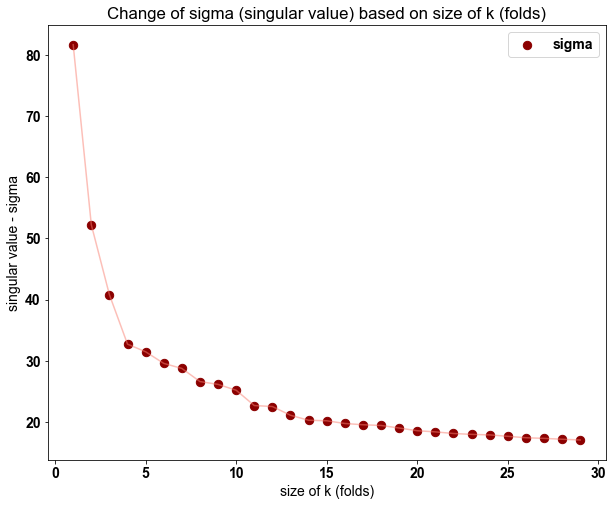

In [28]:
# Grafische Darstellung des Singulärwertabfalls (sigma)
calc_optimal_fold(train_set_count, 30)

### Matrix dekomposieren basiered auf sigma
Wie in der obigen Grafik ersichtlich ist der Sprung von sigma_1 zu sigma_2 schon sehr gross und fällt dann nur noch wenig ab. Für die Dekomposition der User-Item Matrix wird sigma_5 verwendet, mit der Annahme, dass diese Singulärwert die relevantesten Informationen enthalten.

In [29]:
# Dekomposition der User-Item Matrix
U, s, VT = svds(train_set_count,5)

In [30]:
# Zeige die jeweiligen Grössen der Matrizen auf. Ziel sollte sein, dass s die Matrizen U und VT durch dot Multiplikation verbunden werden können
print(U.shape)
print(s.shape)
print(VT.shape)

(34703, 5)
(5,)
(5, 9937)


### Rekonsturktion der Bewertungsmatrix
Nach dem die ursprüngliche Matrix dekomposiert wurde und dabei absichtlich eine gewisse Unschärfe durch die Wahl von sigma Implementiert ist, wird diese Unschärfe dazu genutzt um alle Recommendations auf allen Produkten und für alle User zu erstellen. Dazu wird die User-Item Matrix mit den neu erstellten Matrix Rekonstruiert

In [31]:
# den sigma array in eine Diagonalmatrix umrechnen
sigma_diag_matrix=np.diag(s)

In [32]:
# Rekonstruktion der Bewertungsmatrix (User-Item) 
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), VT)

### Umwandlung der benötigten Matrizen in ein Pandas Frame für die einfachere Handhabung

In [33]:
# Transformation der Recommendationmatrix in ein Pandas DataFrame für eine einfachere Handhabung beim ITEM Lockup
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users, index = products)
preds_df.head(3)

,1,10,23,25,28,32,34,37,44,45,...,49630,49633,49640,49644,49652,49655,49667,49678,49680,49683
17,0.000016,0.000029,0.000009,0.000027,0.000005,0.000006,0.000085,0.000008,0.000009,0.000273,...,0.000009,0.000005,0.000005,0.000009,0.000006,0.000007,0.000014,0.000003,0.000024,0.001514
21,0.000210,0.000451,0.000128,0.000392,0.000094,0.000127,0.001384,0.000147,0.000117,0.004714,...,0.000163,0.000078,0.000030,0.000163,0.000084,0.000115,0.000241,0.000055,0.000406,0.027833
27,0.000080,0.000650,0.000267,0.000665,0.000072,0.000172,0.001841,0.000101,0.000226,0.004267,...,0.000120,0.000041,0.000301,0.000084,0.000142,0.000338,0.000324,0.000034,0.000234,0.014520


In [34]:
del U, VT, s, max_fold, sigma_diag_matrix

### Testlauf um Recommendations für einen User zu erstellen

In [35]:
# Rekonstruiere Matrix von Einkäufen
matrix_count_dense = pd.DataFrame(matrix_count.todense(), index = products, columns = users)

# Die Top Produkte die  User 27 gekauft hat
matrix_count_dense.loc[27].sort_values(ascending=False).head()

2966     1.000000
1194     0.741935
14233    0.645161
33787    0.612903
33754    0.548387
Name: 27, dtype: float64

In [36]:
# Speichers der Produkte
products_user_27 = matrix_count_dense.loc[27]

In [37]:
# Benutze nur die gekaufte Produkte
bought_products_user_27 = products_user_27[products_user_27 > 0].index

In [38]:
# Extrahiere die Vorschläge aus den berechneten Vorschlägen
products_recommended_for_27 = preds_df.loc[27].sort_values(ascending=False)
products_recommended_for_27 = products_recommended_for_27.index

In [39]:
# Berechne die Differenz zwischen schon gekauften Produkten und den kompletten vorgeschlagenen Produkten
#res = set(products_recommended_for_27) - set(bought_products_user_27)
res = products_recommended_for_27.difference(bought_products_user_27, sort=False)

In [40]:
# Extrahiere nur die 5 höchstbewertesten Vorschläge für User 27 
products_high_recommend_for_27 = res[:5]

### Es ist hier zu sehen, dass für den User 27 folgende Produkte vorgeschlagen werden:

In [41]:
products_high_recommend_for_27

Int64Index([27845, 8277, 40706, 22935, 22035], dtype='int64')

In [42]:
del res, products_high_recommend_for_27, products_recommended_for_27, bought_products_user_27, products_user_27, users, products, preds_df

# Evaluation
Bei der Evaluation wird das Test-Set in zwei Teile aufgeteilt (der Split geschieht im Datenverarbeitungsmodul), das Test- und das Trainingset. Hierbei befinden sich 90% der User im Trainingset. Für die Daten im Testset ist zudem zu beachten, dass es sich um User handelt welche tendenziell eine grosse Anzahl an Ratings aufweisen.  Dabei wird der Recommender mit dem Training-Set angelernt und mit dem Test-Set auf seine Leistung getestet. Bei den Usern im Testset werden einzelne Ratings entfernt (maskiert), welche dann mittels des Recommenders möglichst wieder errechnet werden. Als Beispiel:
Bei User A werden von total 40 bewerteten Items, bei 10 Items die Ratings entfernt. Anschliessend werden die Top 10 Recommendations für User A berechnet. Je grösser die Übereinstimmung der berechneten Recommendations, mit den zuvor gelöschten Items von User A ist, desto besser funktioniert der Recommender für User A. Dieser Schritt wird für sämtliche User aus dem Testset wiederholt. Der Durchschnitt aller berechneten Recommendations gegenüber ihren tatsächlichen Ratings, ergibt die Genauigkeit der Vorhersage für den verwendeten Recommender. 


## Memory-Based Recommender

# @ Lukas: 
### Habe dir deine precision und recall formel umgeschrieben. So dass beide werte gleichzietig rauskommen und nicht für beides die kompletten recommendations berechnet werden müssen. 
# To Do für Lukas:
- Formeln aus Evaluation entfernen, die neue heisst: evaluation_memory_based_user
- die Codeblöcke die nicht mehr gebraucht werden aus dem Notebook entfernen
- Die Formeln aus der Evaluierung entfernen die nicht benötigt werden für den durchschnitt (habe dir eine geschrieben unten, diese funktioniert gleich mit der Grafik)

In [43]:
# Berechnung von Precision@N und Recall@N für UBCF für einen User
# Anzahl in den Top N Recommendation enthaltenen Produkte geteilt durch die Anzahl empfohlener Produkte
# Anzahl in den Top N Recommendation enthaltenen Produkte / Der der maskierten Produkte

evaluation_memory_based_user(train_set_unary,sim,user_neighbours,index_masked_unary,10,5)

(0.0, 0.0)

In [45]:
# Get a list of number of recommendations per user to check
recommendations = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100]

# Number of random users to use 
N = 20

# Number of times to iterrate to get the average
iter = 5

# Create empty lists 
average_precision = []
average_recall = []
average_f1 = []

# iterrate over 100 random users 10 times to get an average precision and recall
for rec in recommendations:
    aver_precision = 0
    aver_recall = 0
    for i in range(iter):
        precision, recall = evaluation_memory_based_model(users_masked_unary, N, train_set_unary, sim, user_neighbours, index_masked_unary, rec)
        aver_precision += precision
        aver_recall += recall
    
    aver_precision = aver_precision / iter
    aver_recall = aver_recall / iter

    if (aver_recall+aver_precision) == 0:
        f1_score = 0
    else:
        f1_score = 2* (aver_recall*aver_precision) / (aver_precision+aver_recall)

    average_precision.append(aver_precision)
    average_recall.append(aver_recall)
    average_f1.append(f1_score)

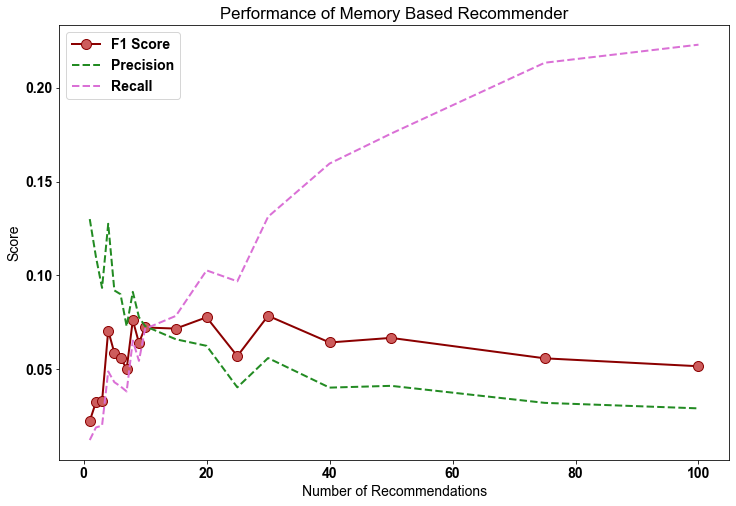

In [46]:
plt.figure(figsize=(12,8))
plt.plot(recommendations, average_f1, marker='o', markerfacecolor='indianred', markersize=10, color='darkred', lw=2, label='F1 Score')
plt.plot(recommendations, average_precision, marker='', color='forestgreen', lw=2, linestyle='dashed', label='Precision')
plt.plot(recommendations, average_recall,  marker='', color='orchid', lw=2, linestyle='dashed', label="Recall")
plt.xlabel('Number of Recommendations')
plt.ylabel('Score')
plt.title('Performance of Memory Based Recommender')
plt.legend()

# @Lukas: ich denke ab hier kann gelöscht werden bis zum Model Based Recommender

In [47]:
# Berechnung von Precision@N für UBCF für einen User
# Anzahl in den Top N Recommendation enthaltenen Produkte geteilt durch die Anzahl empfohlener Produkte

precision(train_set_unary,sim,user_neighbours,index_masked_unary,10,5)

TypeError: 'float' object is not callable

In [ ]:
# Berechnung von Recall@N für UBCF für einen User
# Anzahl in den Top N Recommendation enthaltenen Produkte / Der der maskierten Produkte

recall(train_set_unary,sim,user_neighbours,index_masked_unary,10,5)


In [ ]:
# Um aussagekräftige Ergebnisse zu bekommen muss ein Test N mal wiederholt werden

repeat_test('precision',train_set_unary,sim,user_neighbours,index_masked_unary,1,users_masked_unary,20)


In [ ]:
%%time
repeat_test('recall',train_set_unary,sim,user_neighbours,index_masked_unary,1,users_masked_unary,20)

In [ ]:
# Berechnung von Precision@N und Recall@N für UBCF für n User
precision_ubcf, recall_ubcf = evaluate_ubcf(train_set_unary,sim,user_neighbours,index_masked_unary,1,users_masked_unary,20)

print(precision_ubcf,recall_ubcf)

## Model Based Recommender

In [56]:
# Berechnung von Precision@N und Recall@N für SVD für einen User

# Precision: Anzahl in den Top N Recommendation enthaltenen Produkte geteilt durch die Anzahl empfohlener Produkte
# Recall: Anzahl in den Top N Recommendation enthaltenen Produkte geteilt durch die Anzahl relevanten Produkte

evaluation_model_based_user(50, all_user_predicted_ratings, index_masked_count, train_set_count, 10)

(0.1, 0.125)

In [59]:
# Get a list of number of recommendations per user to check
recommendations = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100]

# Number of random users to use 
N = 20

# Number of times to iterrate to get the average
iter = 5

# Create empty lists 
average_precision = []
average_recall = []
average_f1 = []

# iterrate over 100 random users 10 times to get an average precision and recall
for rec in recommendations:
    print(rec)
    aver_precision = 0
    aver_recall = 0
    for i in range(iter):
        print(i)
        precision, recall = evaluation_model_based_model(users_masked_count, N, all_user_predicted_ratings, index_masked_count, train_set_count, rec)
        aver_precision += precision
        aver_recall += recall
    
    aver_precision = aver_precision / iter
    aver_recall = aver_recall / iter

    if (aver_recall+aver_precision) == 0:
        f1_score = 0
    else:
        f1_score = 2* (aver_recall*aver_precision) / (aver_precision+aver_recall)

    average_precision.append(aver_precision)
    average_recall.append(aver_recall)
    average_f1.append(f1_score)

1
0
1
2


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(recommendations, average_f1, marker='o', markerfacecolor='indianred', markersize=10, color='darkred', lw=2, label='F1 Score')
plt.plot(recommendations, average_precision, marker='', color='forestgreen', lw=2, linestyle='dashed', label='Precision')
plt.plot(recommendations, average_recall,  marker='', color='orchid', lw=2, linestyle='dashed', label="Recall")
plt.xlabel('Number of Recommendations')
plt.ylabel('Score')
plt.title('Performance of Model Based Recommender')
plt.legend()